# Aggregate analyses

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import uuid
import hmac

In [2]:
rc = {'axes.facecolor':'white',
      'axes.edgecolor': 'white',
      'axes.grid' : True,
      'grid.color': '.7',
      'font.family':'Helvetica',
      'font.size' : 20,
      'xtick.major.width': 0,
      'ytick.major.width': 0,
      'figure.dpi': 300}
plt.rcParams.update(rc)

## Read the email data

In [3]:
emails = pd.read_pickle('../data/release/v1.0/corpus_v1.0.pkl')

In [4]:
emails.columns.values

array(['from_name', 'from_address', 'subject', 'body_text', 'uid', 'name',
       'office_sought', 'party_affiliation', 'office_level',
       'district_type', 'final_website', 'crawl_date', 'source', 'state',
       'type', 'subtype', 'date', 'hour', 'day', 'uid_email', 'uid_inbox',
       'incumbent'], dtype=object)

In [5]:
emails['office_sought'] = emails['office_sought'].fillna(value='None')

In [6]:
emails['from_address_domain'] = emails['from_address'].apply(lambda x: x.split('@')[1] if '@' in x else x)

In [8]:
len(emails), len(set(emails['uid_inbox']))

(317366, 3091)

## Read in the scores

In [9]:
urgency_score = pd.read_pickle('../data/output/emails_urgency_score.pkl').set_index(emails.index)['urgency_score']
forward_referencing_score = pd.read_pickle('../data/output/emails_forward_referencing_score.pkl').set_index(emails.index)['forward_referencing_score']
sensationalism_score = pd.read_pickle('../data/output/emails_sensationalism_score.pkl').set_index(emails.index)['sensationalism_score']
obscured_name_score = pd.read_pickle('../data/output/emails_obscured_name_score.pkl').set_index(emails.index)['obscured_name_score']
deceptive_from_thread_score = pd.read_pickle('../data/output/emails_deceptive_from_thread_score.pkl').set_index(emails.index)['deceptive_from_thread_score']
deceptive_re_fwd_score = pd.read_pickle('../data/output/emails_deceptive_re_fwd_score.pkl').set_index(emails.index)['deceptive_re_fwd_score']


emails['urgency_score'] = urgency_score
emails['forward_referencing_score'] = forward_referencing_score
emails['sensationalism_score'] = sensationalism_score
emails['obscured_name_score'] = obscured_name_score
emails['deceptive_from_thread_score'] = deceptive_from_thread_score
emails['deceptive_re_fwd_score'] = deceptive_re_fwd_score

In [10]:
emails.to_pickle('../data/output/dataframe_scored.pkl')

In [11]:
score_types = ['obscured_name_score', 'forward_referencing_score',\
               'urgency_score', 'sensationalism_score', 'deceptive_from_thread_score', 'deceptive_re_fwd_score']

## How do our scores compare to the coded sample?

In [12]:
coded = pd.read_csv('../data/learning/subject_sample_coded_holdout.csv')
coded.columns

Index(['Unnamed: 0', 'uid', 'office_sought', 'party_affiliation', 'incumbent',
       'office_level', 'district_type', 'final_website', 'crawl_date',
       'source', 'state', 'type', 'subtype', 'date', 'hour', 'day',
       'from_address', 'name', 'from_name', 'subject', 'sensationalism',
       'forward_referencing', 'urgency', 'obscured_name', 'deceptive_re_fwd',
       'deceptive_from_thread'],
      dtype='object')

Prevalence:

In [13]:
len(coded[(coded['urgency']) | (coded['forward_referencing']) | (coded['sensationalism']) | (coded['obscured_name']) | (coded['deceptive_re_fwd']) | (coded['deceptive_from_thread'])])/len(coded)

0.65

In [14]:
def get_scores(row):
    df = emails[(emails['uid'] == row['uid'])]
    
    assert len(df) == 1
    
    return df[score_types[0]].iloc[0], df[score_types[1]].iloc[0], df[score_types[2]].iloc[0],\
            df[score_types[3]].iloc[0], df[score_types[4]].iloc[0], df[score_types[5]].iloc[0]

coded[score_types[0]], coded[score_types[1]], coded[score_types[2]],\
coded[score_types[3]], coded[score_types[4]], coded[score_types[5]] = zip(*coded.apply(get_scores, axis=1))

Product of probabilities:

In [15]:
coded['manipulative_prod'] = (1 - coded['urgency_score']) *\
(1 - coded['obscured_name_score'])*\
(1 - coded['deceptive_from_thread'])*\
(1 - coded['deceptive_re_fwd'])*\
(1 - coded['sensationalism_score'])*\
(1 - coded['forward_referencing_score'])

1 - np.mean(coded['manipulative_prod'])

0.691570935210295

In [16]:
s = (1 - emails['urgency_score']) *\
(1 - emails['obscured_name_score'])*\
(1 - emails['deceptive_from_thread_score'])*\
(1 - emails['deceptive_re_fwd_score'])*\
(1 - emails['sensationalism_score'])*\
(1 - emails['forward_referencing_score'])

1 - np.mean(s)

0.6596546360528407

Max:

In [17]:
coded['manipulative_max'] = coded[score_types].max(axis=1)
np.mean(coded['manipulative_max'])

0.6550475657029828

In [18]:
s = emails[score_types].max(axis=1)
np.mean(s)

0.6287206783853087

## Retain active senders

In [19]:
active = emails.groupby('uid_inbox').apply(lambda x: x.sort_values('date').iloc[1:, 1:])
active = active.reset_index(level=0, drop=True)
active = active.groupby('uid_inbox').filter(lambda x: len(x) >= 10)

In [20]:
len(active), len(set(active['uid_inbox']))

(311555, 1401)

In [21]:
active.columns

Index(['from_address', 'subject', 'body_text', 'uid', 'name', 'office_sought',
       'party_affiliation', 'office_level', 'district_type', 'final_website',
       'crawl_date', 'source', 'state', 'type', 'subtype', 'date', 'hour',
       'day', 'uid_email', 'uid_inbox', 'incumbent', 'from_address_domain',
       'urgency_score', 'forward_referencing_score', 'sensationalism_score',
       'obscured_name_score', 'deceptive_from_thread_score',
       'deceptive_re_fwd_score'],
      dtype='object')

## Aggregate over active senders

Aggregation function:

In [22]:
def calc_product(row):
    sc = (1 - row[score_types[0]]) *\
         (1 - row[score_types[1]])*\
         (1 - row[score_types[2]])*\
         (1 - row[score_types[3]])*\
         (1 - row[score_types[4]])*\
         (1 - row[score_types[5]])
    
    return 1 - np.mean(sc)

def calc_max(row):
    sc = row[score_types].max(axis=1)
    return np.mean(sc)

In [24]:
cols = ['uid_inbox', 'name', 'source']
cols.extend(score_types)
product_frame = active[cols].groupby(['uid_inbox', 'name', 'source'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('fraction', ascending=False)
product_frame.head(50)

,uid_inbox,name,source,fraction
981,b2273d4fbd56599a29788cec61f96ac2,Progressive Turnout Project,orgs,0.971889
1276,ebbbf4c428109ae77ae56c76479364cd,UNITEDemocrats PAC,orgs,0.968959
635,71348ce1988a9f290a382f298dbfe587,Brady PAC,orgs,0.964153
768,8ae56f54cb207a656d91a5d30bf5ca4c,Democratic Conservation Alliance,orgs,0.959288
1124,ce579a7d8373de6d8abb26369f3b8a7d,Medicare for All PAC,orgs,0.958961
1351,f79a16d5f707af05bf8de56de6cb38fa,Elect Democratic Women,orgs,0.958785
955,ad1093e01707b221430f7b972695d485,Stop Republicans PAC,orgs,0.951180
1196,db2e0ec2af5f41f1c1953417b7d61677,Ginger Bock,ballotpedia-campaign,0.950341
1132,cf40584c8ca613be4384bce1a20ff36c,Congressional Progressive Caucus PAC,orgs,0.950032
1286,ec90cfd0ad39ddcbefae7c80a186b99f,Christy Zito,ballotpedia-campaign,0.948501


In [25]:
len(product_frame[product_frame['fraction'] <= 0.1])/len(product_frame)

0.010706638115631691

In [26]:
len(product_frame[product_frame['fraction'] >= 0.66])/len(product_frame)

0.10706638115631692

In [27]:
product_frame[product_frame['fraction'] >= 0.66][:10]

,uid_inbox,name,source,fraction
981,b2273d4fbd56599a29788cec61f96ac2,Progressive Turnout Project,orgs,0.971889
1276,ebbbf4c428109ae77ae56c76479364cd,UNITEDemocrats PAC,orgs,0.968959
635,71348ce1988a9f290a382f298dbfe587,Brady PAC,orgs,0.964153
768,8ae56f54cb207a656d91a5d30bf5ca4c,Democratic Conservation Alliance,orgs,0.959288
1124,ce579a7d8373de6d8abb26369f3b8a7d,Medicare for All PAC,orgs,0.958961
1351,f79a16d5f707af05bf8de56de6cb38fa,Elect Democratic Women,orgs,0.958785
955,ad1093e01707b221430f7b972695d485,Stop Republicans PAC,orgs,0.951180
1196,db2e0ec2af5f41f1c1953417b7d61677,Ginger Bock,ballotpedia-campaign,0.950341
1132,cf40584c8ca613be4384bce1a20ff36c,Congressional Progressive Caucus PAC,orgs,0.950032
1286,ec90cfd0ad39ddcbefae7c80a186b99f,Christy Zito,ballotpedia-campaign,0.948501


In [28]:
product_frame.to_csv('../data/plots/product_frame.csv')

In [30]:
max_frame = active[cols].groupby(['uid_inbox', 'name', 'source'], dropna=False).apply(calc_max).reset_index(name='fraction').sort_values('fraction', ascending=False)
max_frame

,uid_inbox,name,source,fraction
1276,ebbbf4c428109ae77ae56c76479364cd,UNITEDemocrats PAC,orgs,0.959009
981,b2273d4fbd56599a29788cec61f96ac2,Progressive Turnout Project,orgs,0.955840
768,8ae56f54cb207a656d91a5d30bf5ca4c,Democratic Conservation Alliance,orgs,0.939746
1124,ce579a7d8373de6d8abb26369f3b8a7d,Medicare for All PAC,orgs,0.939692
1351,f79a16d5f707af05bf8de56de6cb38fa,Elect Democratic Women,orgs,0.939018
...,...,...,...,...
270,34d7a5b245fe7bb697adec278993c4e3,Sally Toone,ballotpedia-campaign,0.035133
448,51d359f1377c2ff3cf2827661eb3265b,Merleyn Bell,ballotpedia-campaign,0.034974
625,6f543e3f872ecbb807719b00266b6d5d,Regina Barnes,ballotpedia-campaign,0.029007
1156,d26e96909aef4468705faf86d23855c2,Alec Garnett,ballotpedia-campaign,0.027416


In [31]:
np.median(product_frame['fraction'])

0.4165362760512057

In [32]:
len(product_frame)

1401

In [33]:
np.median(max_frame['fraction'])

0.3829878295655511

In [34]:
len(max_frame)

1401

In [35]:
active[['uid_inbox', 'forward_referencing_score']].groupby('uid_inbox').mean().to_csv('../data/plots/frame_fr.csv')
active[['uid_inbox', 'urgency_score']].groupby('uid_inbox').mean().to_csv('../data/plots/frame_urgency.csv')
active[['uid_inbox', 'sensationalism_score']].groupby('uid_inbox').mean().to_csv('../data/plots/frame_sensationalism.csv')

In [36]:
active[['uid_inbox', 'obscured_name_score']].groupby('uid_inbox').mean().to_csv('../data/plots/frame_ff.csv')
active[['uid_inbox', 'deceptive_from_thread_score']].groupby('uid_inbox').mean().to_csv('../data/plots/frame_ft.csv')
active[['uid_inbox', 'deceptive_re_fwd_score']].groupby('uid_inbox').mean().to_csv('../data/plots/frame_rf.csv')

In [37]:
cols = ['uid_inbox', 'source']
cols.extend(score_types)
frame_source = active[cols].groupby(['uid_inbox', 'source'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('fraction', ascending=False)
frame_source.to_csv('../data/plots/product_frame_source.csv')

cols = ['uid_inbox', 'party_affiliation']
cols.extend(score_types)
frame_party = active[active['source'] == 'ballotpedia-campaign'][cols].groupby(['uid_inbox', 'party_affiliation'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('fraction', ascending=False)
frame_party.to_csv('../data/plots/product_frame_party.csv')

cols = ['uid_inbox', 'office_level']
cols.extend(score_types)
frame_level = active[active['source'] == 'ballotpedia-campaign'][cols].groupby(['uid_inbox', 'office_level'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('fraction', ascending=False)
frame_level.to_csv('../data/plots/product_frame_level.csv')

cols = ['uid_inbox', 'incumbent']
cols.extend(score_types)
frame_incumbency = active[active['source'] == 'ballotpedia-campaign'][cols].groupby(['uid_inbox', 'incumbent'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('fraction', ascending=False)
frame_incumbency.to_csv('../data/plots/product_frame_incumbency.csv')

## Disaggregate active senders by emails shared

In [47]:
leaks = pd.read_csv('../data/leaks/leaks_coded.csv')

In [48]:
leaks.columns

Index(['to_address', 'office_sought', 'type', 'subtype', 'party_affiliation',
       'incumbent?', 'office_level', 'district_type', 'source', 'name',
       'final_website', 'from_address', 'from_address_domain',
       'from_address_domain_type', 'from_address_org',
       'from_address_domain_office_level', 'mailing_list', 'notes'],
      dtype='object')

In [49]:
key = open('/Users/aruneshmathur/.ssh/id_rsa', 'rb').read()
leaks['uid_inbox'] = leaks.apply(lambda x: hmac.new(key, (x['to_address']).encode(), digestmod='md5').hexdigest(), axis=1)
del leaks['to_address']

In [50]:
active_all = active.merge(leaks[['uid_inbox', 'from_address', 'mailing_list']], on=['uid_inbox', 'from_address'], how='left')

In [51]:
active_all['mailing_list'] = active_all['mailing_list'].fillna('no')

In [52]:
active_noleaks = active_all[active_all['mailing_list'] == 'no']

In [53]:
active_leaks = active_all[active_all['mailing_list'] == 'yes']

In [54]:
len(active_noleaks)

147519

In [55]:
len(active_leaks)

164036

In [56]:
cols = ['uid_inbox', 'name', 'source']
cols.extend(score_types)
product_frame_noleaks = active_noleaks[cols].groupby(['uid_inbox', 'name', 'source'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('fraction', ascending=False)
product_frame_noleaks.head(50)

,uid_inbox,name,source,fraction
11,0281c45f4a14a5bca4bd093933ef2a73,LMG PAC,orgs,0.981963
1108,ce579a7d8373de6d8abb26369f3b8a7d,Medicare for All PAC,orgs,0.974099
966,b2273d4fbd56599a29788cec61f96ac2,Progressive Turnout Project,orgs,0.971889
1334,f79a16d5f707af05bf8de56de6cb38fa,Elect Democratic Women,orgs,0.970630
755,8ae56f54cb207a656d91a5d30bf5ca4c,Democratic Conservation Alliance,orgs,0.969335
1259,ebbbf4c428109ae77ae56c76479364cd,UNITEDemocrats PAC,orgs,0.968959
940,ad1093e01707b221430f7b972695d485,Stop Republicans PAC,orgs,0.966813
624,71348ce1988a9f290a382f298dbfe587,Brady PAC,orgs,0.964153
1074,c7785e0ad573a572df48719ad8df9a37,Committee for Hispanic Causes-BOLD PAC,orgs,0.956910
1269,ec90cfd0ad39ddcbefae7c80a186b99f,Christy Zito,ballotpedia-campaign,0.948501


In [57]:
product_frame_noleaks.to_csv('../data/plots/product_frame_noleaks.csv')

How does removing shared emails affect the rankings?

In [58]:
product_frame['rank'] = pd.Series(range(1, len(product_frame) + 1), index=product_frame.index)
product_frame

,uid_inbox,name,source,fraction,rank
981,b2273d4fbd56599a29788cec61f96ac2,Progressive Turnout Project,orgs,0.971889,1
1276,ebbbf4c428109ae77ae56c76479364cd,UNITEDemocrats PAC,orgs,0.968959,2
635,71348ce1988a9f290a382f298dbfe587,Brady PAC,orgs,0.964153,3
768,8ae56f54cb207a656d91a5d30bf5ca4c,Democratic Conservation Alliance,orgs,0.959288,4
1124,ce579a7d8373de6d8abb26369f3b8a7d,Medicare for All PAC,orgs,0.958961,5
...,...,...,...,...,...
1032,bab27c1e4e203c294befc5a7b17d18ec,Raymond Smith Jr.,ballotpedia-campaign,0.057427,1397
103,1425d1ec8e03d6ae610411bc016f29c0,Gina Johnsen,ballotpedia-campaign,0.055844,1398
448,51d359f1377c2ff3cf2827661eb3265b,Merleyn Bell,ballotpedia-campaign,0.054352,1399
299,3c14d5a2cd50362e4f50e127c2058b25,Mark Richardson,ballotpedia-campaign,0.048128,1400


In [59]:
product_frame_noleaks['rank'] = pd.Series(range(1, len(product_frame_noleaks) + 1), index=product_frame_noleaks.index)
product_frame_noleaks

,uid_inbox,name,source,fraction,rank
11,0281c45f4a14a5bca4bd093933ef2a73,LMG PAC,orgs,0.981963,1
1108,ce579a7d8373de6d8abb26369f3b8a7d,Medicare for All PAC,orgs,0.974099,2
966,b2273d4fbd56599a29788cec61f96ac2,Progressive Turnout Project,orgs,0.971889,3
1334,f79a16d5f707af05bf8de56de6cb38fa,Elect Democratic Women,orgs,0.970630,4
755,8ae56f54cb207a656d91a5d30bf5ca4c,Democratic Conservation Alliance,orgs,0.969335,5
...,...,...,...,...,...
105,1615e6184a9bddc4b17cc10c2475b5b8,Jeff Sessions,ballotpedia-campaign,0.052364,1380
294,3c14d5a2cd50362e4f50e127c2058b25,Mark Richardson,ballotpedia-campaign,0.048128,1381
1140,d26e96909aef4468705faf86d23855c2,Alec Garnett,ballotpedia-campaign,0.043594,1382
1194,df378b8dcea68834e86f9ba2278a6395,Ruben Rodriguez,ballotpedia-campaign,0.042655,1383


In [60]:
combined = product_frame.merge(product_frame_noleaks, on=['uid_inbox', 'name', 'source'], suffixes=('_leaks', '_noleaks'))
combined['fraction_diff'] = combined['fraction_leaks'] - combined['fraction_noleaks']

In [61]:
combined = combined.sort_values('fraction_diff', ascending=False)
combined[combined['fraction_diff'] >0.05].head(50)

,uid_inbox,name,source,fraction_leaks,rank_leaks,fraction_noleaks,rank_noleaks,fraction_diff
46,ab484494a4eae4a88158b6ec6fc23b96,Scott Cooper,ballotpedia-campaign,0.815326,51,0.030197,1384,0.785129
7,db2e0ec2af5f41f1c1953417b7d61677,Ginger Bock,ballotpedia-campaign,0.950341,8,0.211771,1269,0.738571
170,df378b8dcea68834e86f9ba2278a6395,Ruben Rodriguez,ballotpedia-campaign,0.632250,176,0.042655,1383,0.589595
41,e49e829bac18c370597977411c468df4,Lorraine Birabil,ballotpedia-campaign,0.829061,46,0.312215,1051,0.516846
29,623faa66950b1ee16e3e99bd58cbefbb,Desiree Tims,ballotpedia-campaign,0.865622,30,0.376569,828,0.489052
27,95cadfe6ebc480e1b8ec39e711a8c335,Brynne Kennedy,ballotpedia-campaign,0.874800,28,0.451939,514,0.422861
193,03cacb195e1c5c8ae7d4987fe10513ff,Chris Hansen,ballotpedia-campaign,0.611061,199,0.188745,1303,0.422315
11,c75fa88b2ff5a4ce066fbb306b4f3db1,Marie Newman,ballotpedia-campaign,0.936297,12,0.523266,304,0.413031
520,1615e6184a9bddc4b17cc10c2475b5b8,Jeff Sessions,ballotpedia-campaign,0.463535,529,0.052364,1380,0.411171
23,4457952ff34104cac5ed814135639a57,Beth Doglio,ballotpedia-campaign,0.887441,24,0.483689,419,0.403752


## Manipulative tactics over time

### All emails

In [62]:
cols = ['date']
cols.extend(score_types)
product_frame = active[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
product_frame

,date,fraction
0,2019-12-02,0.409273
1,2019-12-03,0.405230
2,2019-12-04,0.447449
3,2019-12-05,0.478922
4,2019-12-06,0.559900
...,...,...
333,2020-10-30,0.608676
334,2020-10-31,0.659704
335,2020-11-01,0.654803
336,2020-11-02,0.598624


In [63]:
cols = ['date']
cols.extend(score_types)
active_candidates = active[active['source'] == 'ballotpedia-campaign']
candidate_frame = active_candidates[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
candidate_frame

,date,fraction
0,2019-12-03,0.133994
1,2019-12-04,0.349012
2,2019-12-05,0.418028
3,2019-12-06,0.519925
4,2019-12-07,0.524076
...,...,...
332,2020-10-30,0.593931
333,2020-10-31,0.635675
334,2020-11-01,0.638183
335,2020-11-02,0.585448


In [64]:
cols = ['date']
cols.extend(score_types)
active_orgs = active[active['source'] == 'orgs']
org_frame = active_orgs[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
org_frame

,date,fraction
0,2019-12-02,0.409273
1,2019-12-03,0.432354
2,2019-12-04,0.576739
3,2019-12-05,0.567653
4,2019-12-06,0.610566
...,...,...
333,2020-10-30,0.652451
334,2020-10-31,0.735837
335,2020-11-01,0.704928
336,2020-11-02,0.639256


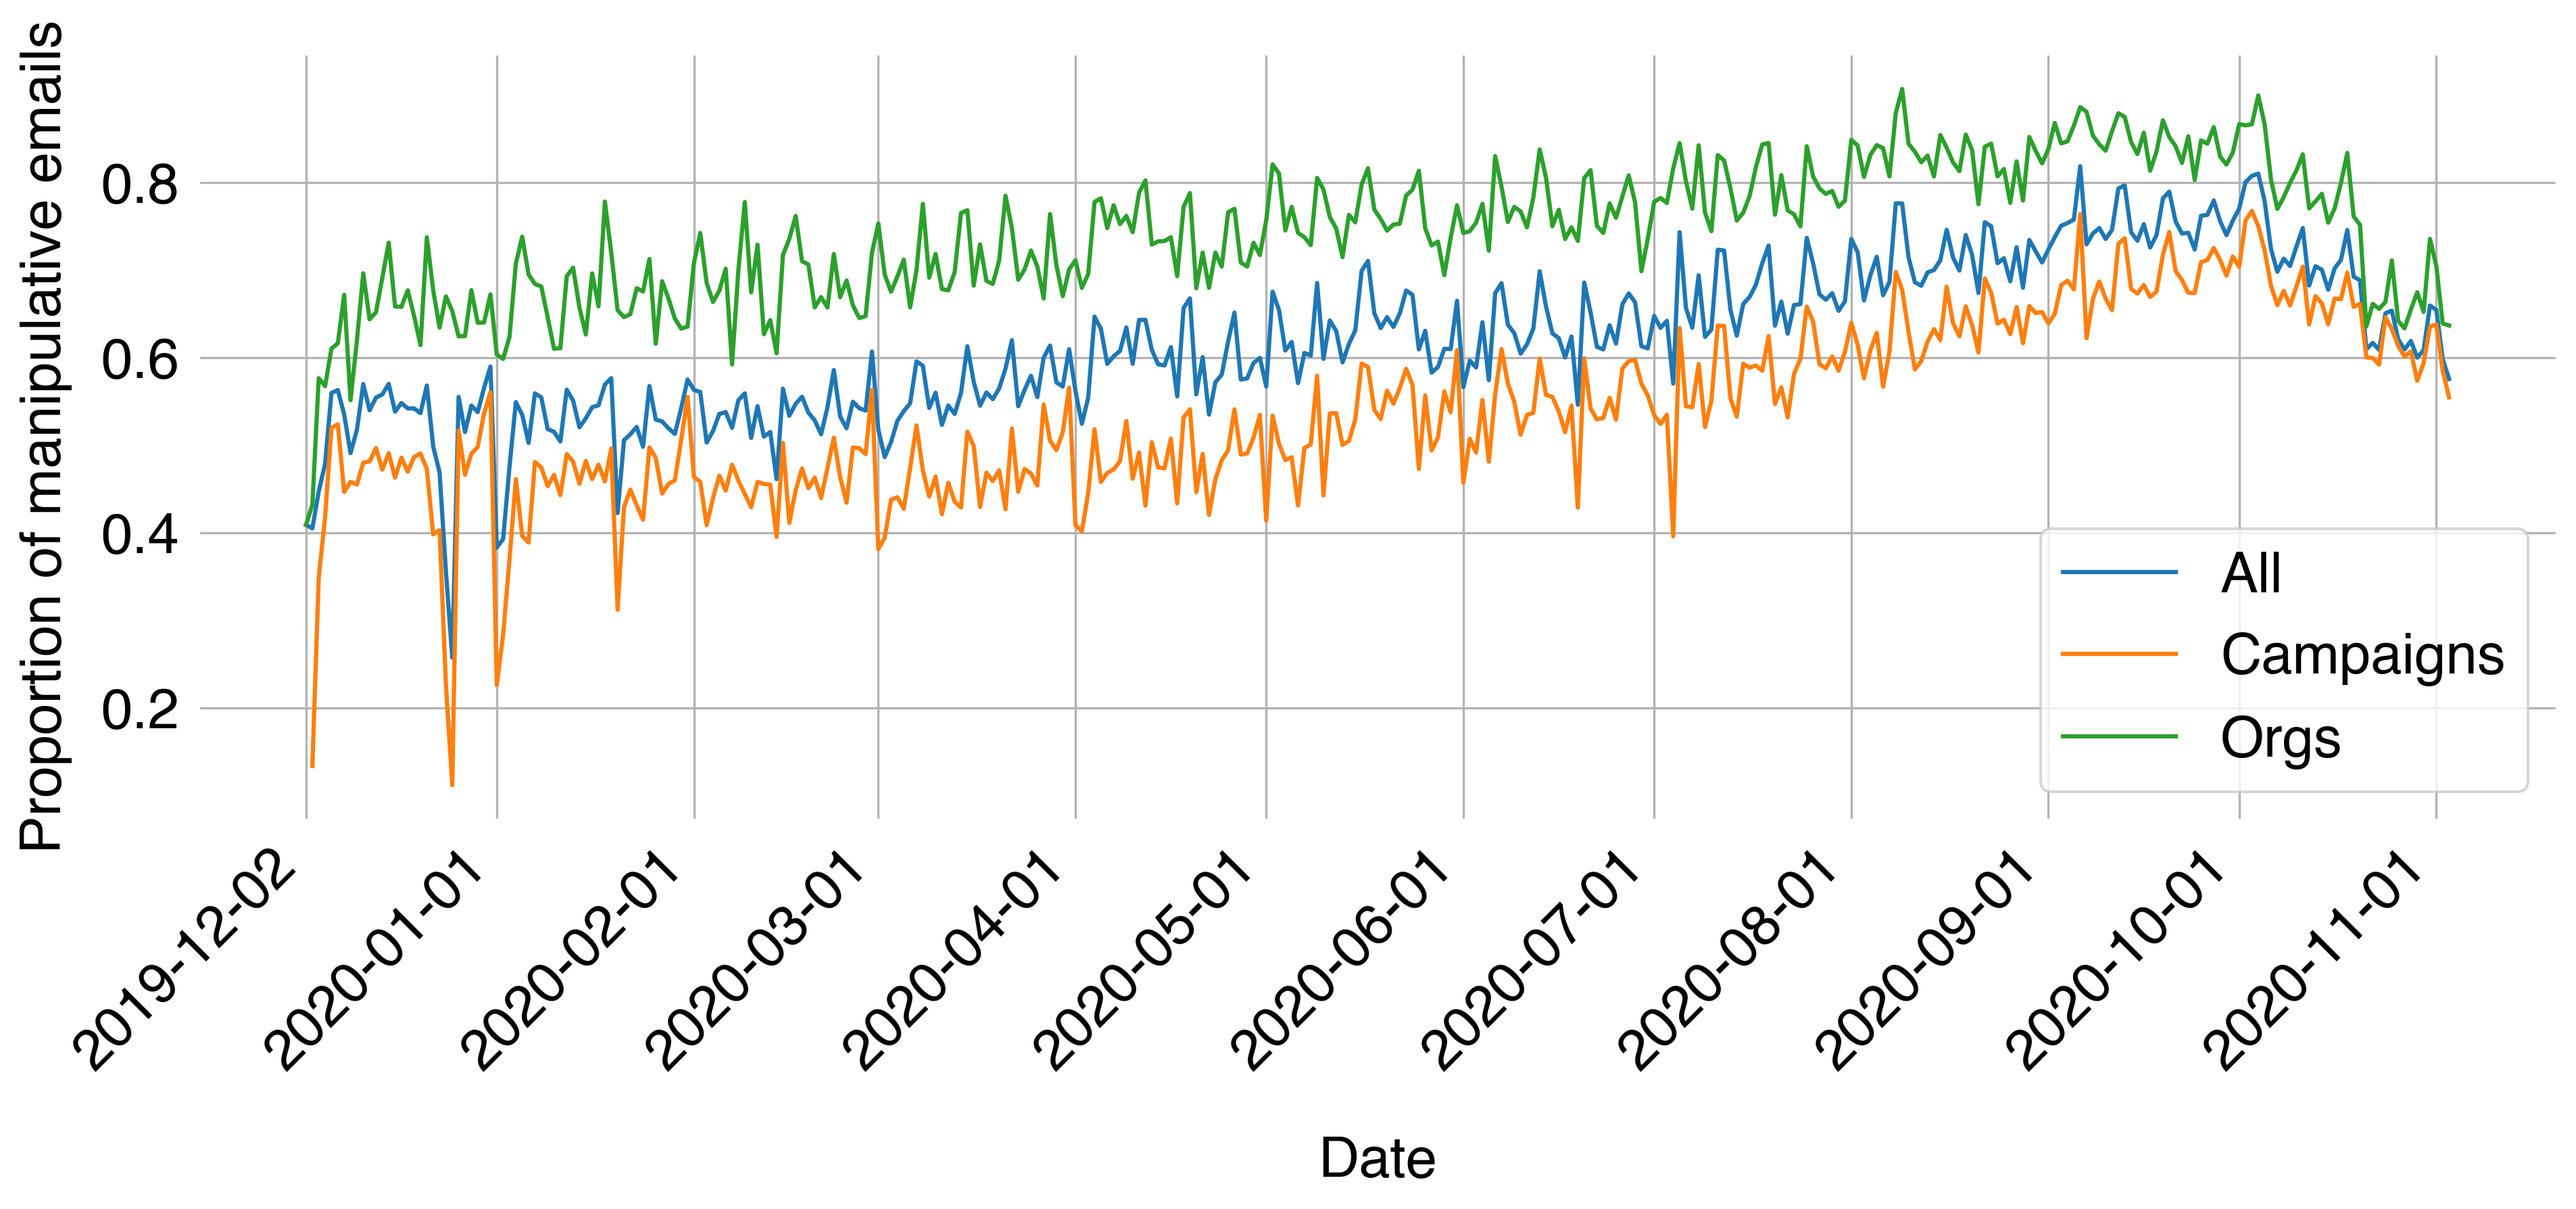

In [65]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='date', y='fraction', data=product_frame, label="All")
ax = sns.lineplot(x='date', y='fraction', data=candidate_frame, label="Campaigns")
ax = sns.lineplot(x='date', y='fraction', data=org_frame, label="Orgs")

ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Proportion of manipulative emails', labelpad=10)

t = list(filter(lambda x: x.endswith('-01') or x.endswith('2019-12-02'), product_frame['date'].to_list()))
ax.set_xticks(t)
ax.set_xticklabels(t, rotation=45, ha='right')

plt.savefig('../data/plots/manipulative_time.png', bbox_inches='tight')

### From original sender

In [66]:
cols = ['date']
cols.extend(score_types)
product_frame = active_noleaks[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
product_frame

,date,fraction
0,2019-12-02,0.409273
1,2019-12-03,0.411770
2,2019-12-04,0.447011
3,2019-12-05,0.485340
4,2019-12-06,0.556505
...,...,...
333,2020-10-30,0.572935
334,2020-10-31,0.611302
335,2020-11-01,0.588467
336,2020-11-02,0.550529


In [67]:
cols = ['date']
cols.extend(score_types)
active_candidates = active_noleaks[active_noleaks['source'] == 'ballotpedia-campaign']
candidate_frame = active_candidates[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
candidate_frame

,date,fraction
0,2019-12-03,0.133994
1,2019-12-04,0.349012
2,2019-12-05,0.418028
3,2019-12-06,0.519925
4,2019-12-07,0.524076
...,...,...
332,2020-10-30,0.546000
333,2020-10-31,0.574441
334,2020-11-01,0.539638
335,2020-11-02,0.520810


In [68]:
cols = ['date']
cols.extend(score_types)
active_orgs = active_noleaks[active_noleaks['source'] == 'orgs']
org_frame = active_orgs[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
org_frame

,date,fraction
0,2019-12-02,0.409273
1,2019-12-03,0.440260
2,2019-12-04,0.586106
3,2019-12-05,0.590967
4,2019-12-06,0.608287
...,...,...
333,2020-10-30,0.644695
334,2020-10-31,0.719797
335,2020-11-01,0.720521
336,2020-11-02,0.636878


[Text(0.0, 0, '2019-12-02'),
 Text(30.0, 0, '2020-01-01'),
 Text(61.0, 0, '2020-02-01'),
 Text(90.0, 0, '2020-03-01'),
 Text(121.0, 0, '2020-04-01'),
 Text(151.0, 0, '2020-05-01'),
 Text(182.0, 0, '2020-06-01'),
 Text(212.0, 0, '2020-07-01'),
 Text(243.0, 0, '2020-08-01'),
 Text(274.0, 0, '2020-09-01'),
 Text(304.0, 0, '2020-10-01'),
 Text(335.0, 0, '2020-11-01')]

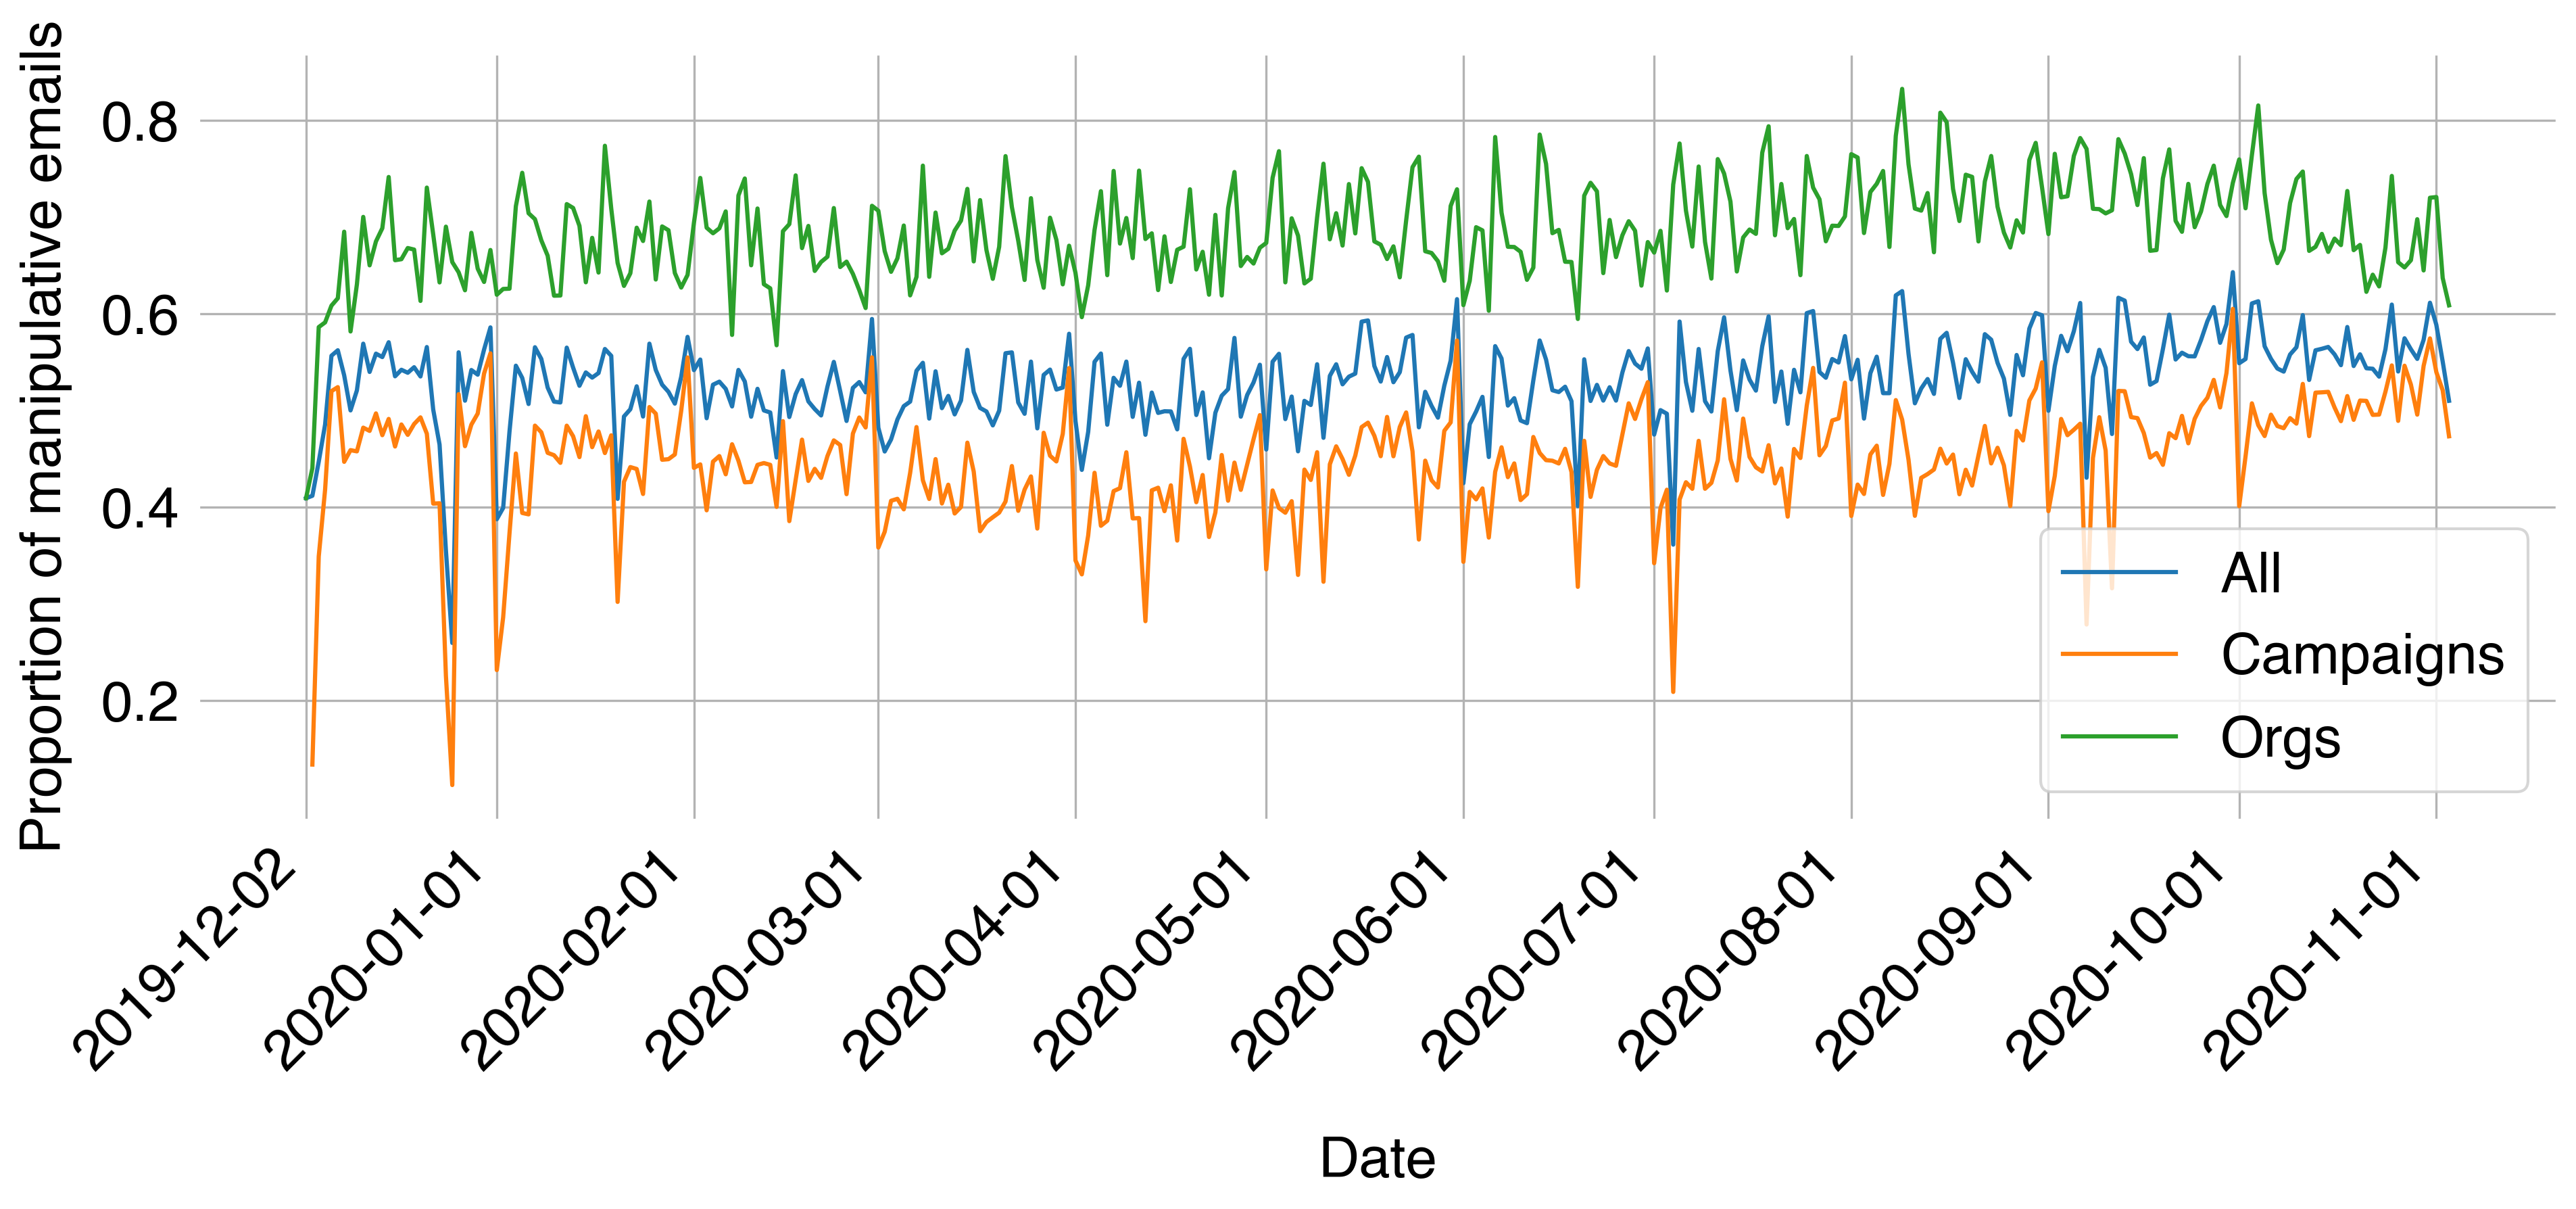

In [69]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='date', y='fraction', data=product_frame, label="All")
ax = sns.lineplot(x='date', y='fraction', data=candidate_frame, label="Campaigns")
ax = sns.lineplot(x='date', y='fraction', data=org_frame, label="Orgs")

ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Proportion of manipulative emails', labelpad=10)

t = list(filter(lambda x: x.endswith('-01') or x.endswith('2019-12-02'), product_frame['date'].to_list()))
ax.set_xticks(t)
ax.set_xticklabels(t, rotation=45, ha='right')

### From emails as a result of sharing

In [70]:
cols = ['date']
cols.extend(score_types)
product_frame = active_leaks[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
product_frame

,date,fraction
0,2019-12-03,0.123997
1,2019-12-04,0.460587
2,2019-12-05,0.264572
3,2019-12-06,0.630066
4,2019-12-07,0.632619
...,...,...
332,2020-10-30,0.640387
333,2020-10-31,0.699623
334,2020-11-01,0.704737
335,2020-11-02,0.641067


In [71]:
cols = ['date']
cols.extend(score_types)
active_candidates = active_leaks[active_leaks['source'] == 'ballotpedia-campaign']
candidate_frame = active_candidates[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
candidate_frame

,date,fraction
0,2019-12-09,0.353624
1,2019-12-10,0.072900
2,2019-12-11,0.170029
3,2019-12-12,1.000000
4,2019-12-14,0.183990
...,...,...
324,2020-10-30,0.634264
325,2020-10-31,0.684541
326,2020-11-01,0.708811
327,2020-11-02,0.640921


In [72]:
cols = ['date']
cols.extend(score_types)
active_orgs = active_leaks[active_leaks['source'] == 'orgs']
org_frame = active_orgs[cols].groupby(['date'], dropna=False).apply(calc_product).reset_index(name='fraction').sort_values('date', ascending=True)
org_frame

,date,fraction
0,2019-12-03,0.123997
1,2019-12-04,0.460587
2,2019-12-05,0.264572
3,2019-12-06,0.630066
4,2019-12-07,0.632619
...,...,...
331,2020-10-30,0.660498
332,2020-10-31,0.750510
333,2020-11-01,0.691343
334,2020-11-02,0.641542


[Text(29.0, 0, '2020-01-01'),
 Text(60.0, 0, '2020-02-01'),
 Text(89.0, 0, '2020-03-01'),
 Text(120.0, 0, '2020-04-01'),
 Text(150.0, 0, '2020-05-01'),
 Text(181.0, 0, '2020-06-01'),
 Text(211.0, 0, '2020-07-01'),
 Text(242.0, 0, '2020-08-01'),
 Text(273.0, 0, '2020-09-01'),
 Text(303.0, 0, '2020-10-01'),
 Text(334.0, 0, '2020-11-01')]

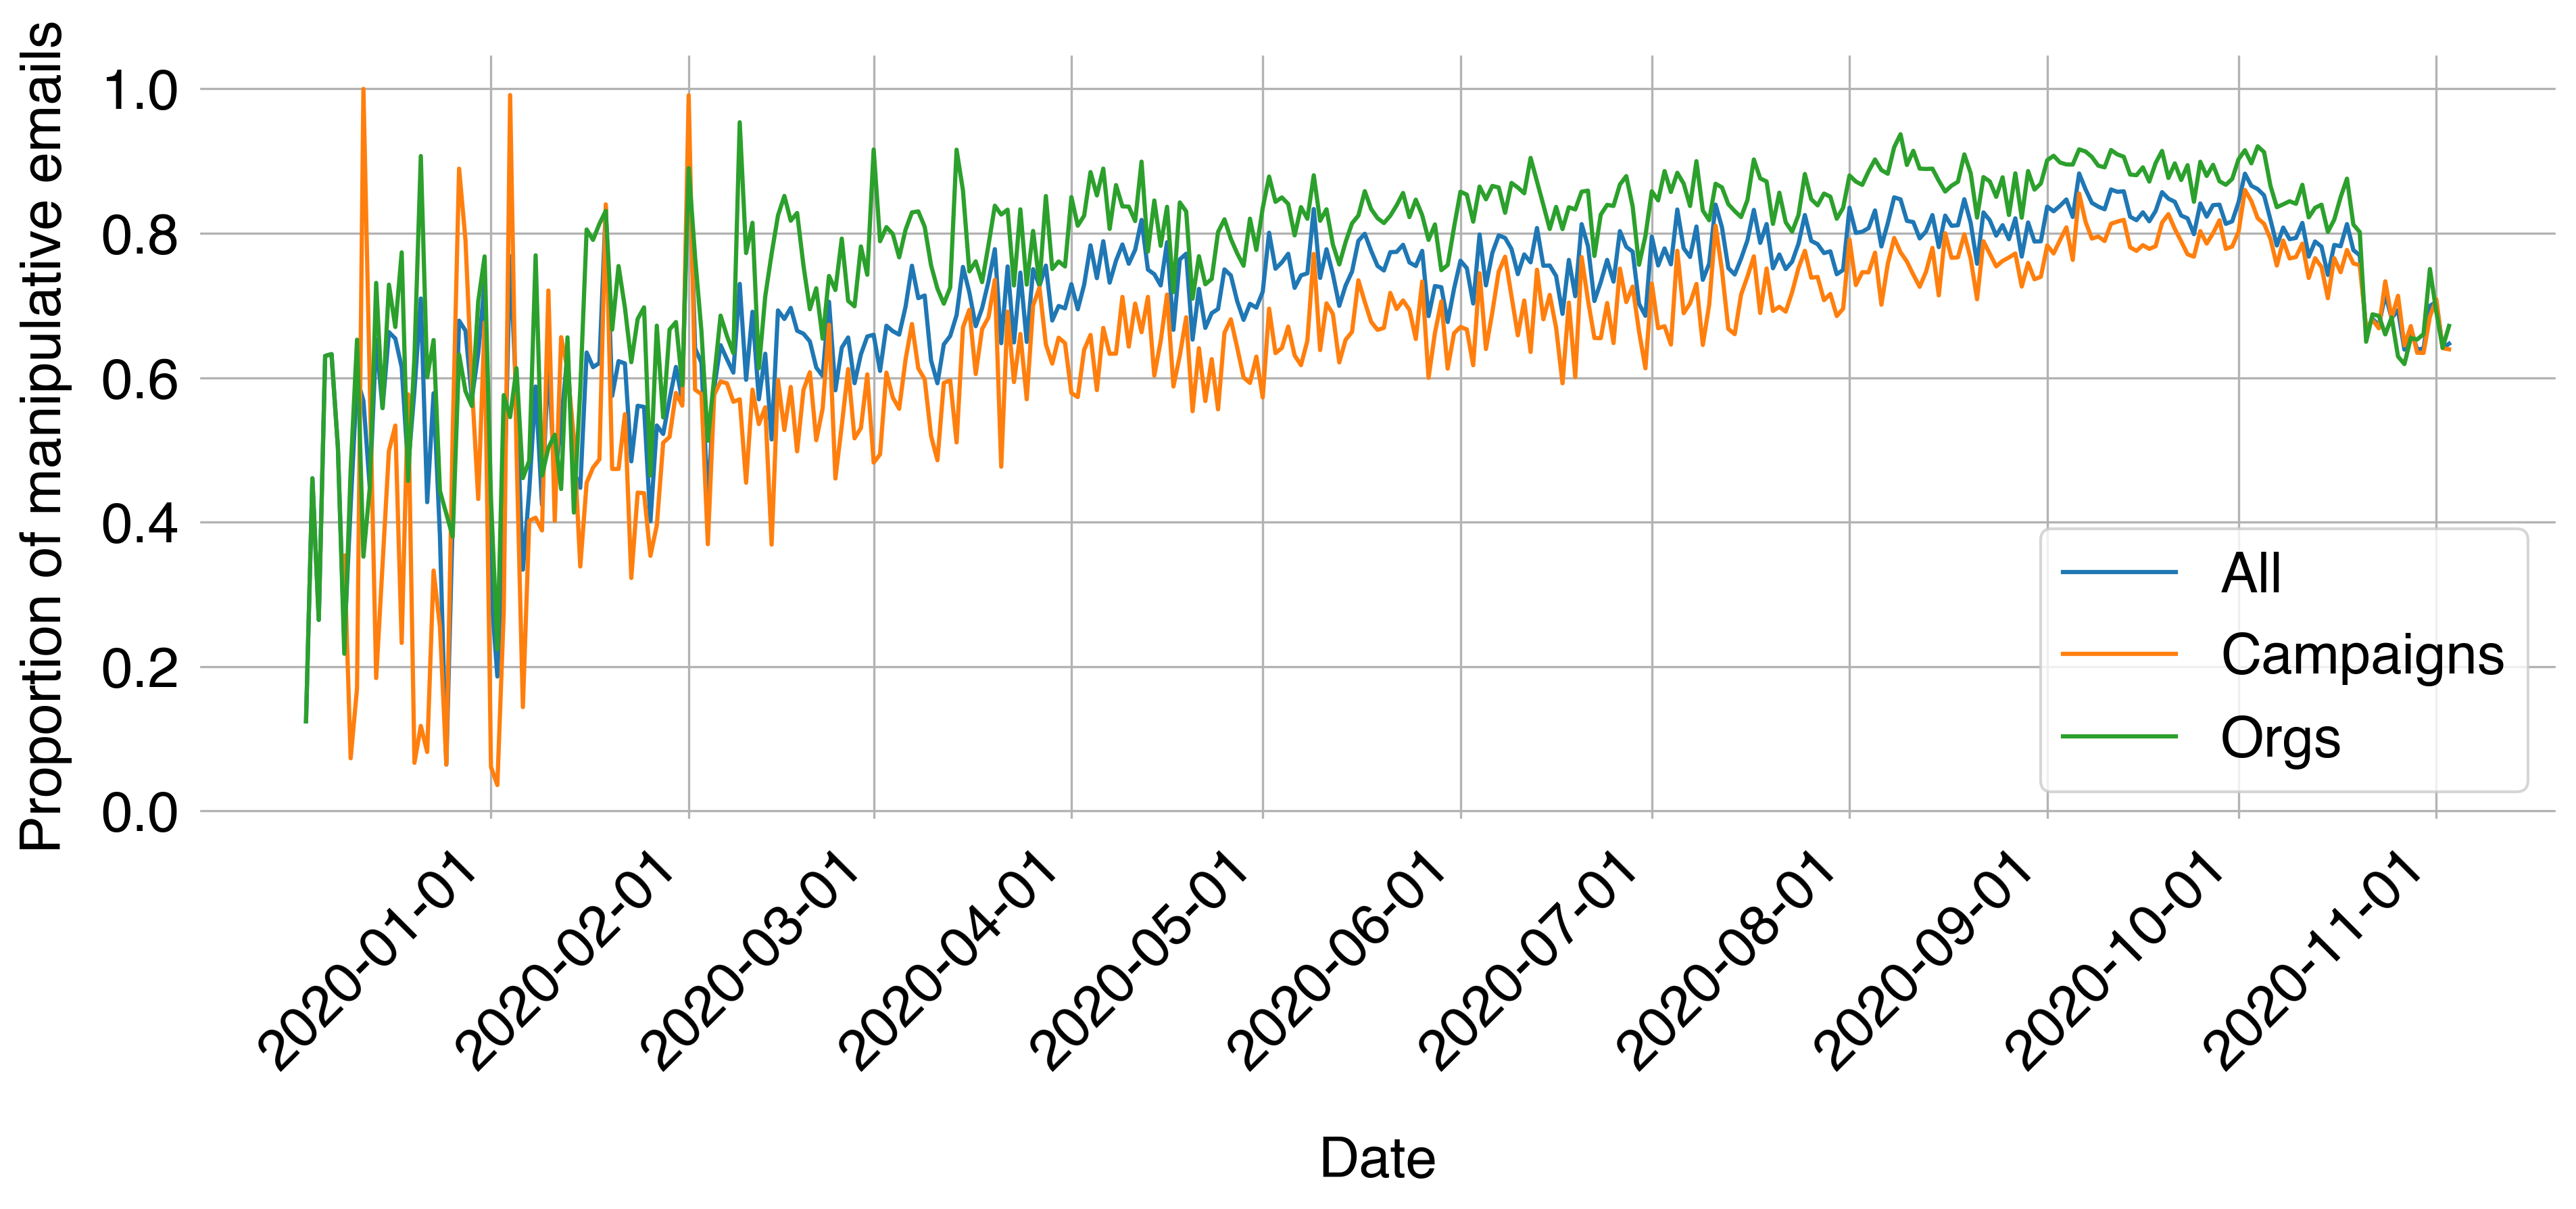

In [73]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='date', y='fraction', data=product_frame, label="All")
ax = sns.lineplot(x='date', y='fraction', data=candidate_frame, label="Campaigns")
ax = sns.lineplot(x='date', y='fraction', data=org_frame, label="Orgs")

ax.set_xlabel('Date', labelpad=20)
ax.set_ylabel('Proportion of manipulative emails', labelpad=10)

t = list(filter(lambda x: x.endswith('-01') or x.endswith('2019-12-02'), product_frame['date'].to_list()))
ax.set_xticks(t)
ax.set_xticklabels(t, rotation=45, ha='right')